# Deep Learning project

The objective of this project is to learn more about:
- Optimizers: You have a variety of Algorithms available at [optim](https://pytorch.org/docs/stable/optim.html). I just want you to select one we have not used (this is, different from SGD or Adam). Use it to train the model and explain what it does.
- Loss functions: Same as before, you have a set of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) available in pytoch for measuring the error in your classification. Again, pick a suitable one (it has to be a multi-class classification metric), explain what it does and use it. 
- Confusion Matrix: The idea is to learn how to make a visualy appealing confusion matrix that easily pinpoints the flaws of the model. You can follow this [blog](https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7) for the task. You don't need to normalise the Confusion matrix if the output size is ok, but try playing around with heatmap's `cmap` option to change colors into something appealing. 

For this task we will use the MNIST dataset (the one with the numbers) and this are the tasks: 
1. Import the data and construct `DataLoader`s for train and test (you can use the code from the Classification-with-NN.ipynb notebook in the SimpleNN folder to import the data)
2. Construct a Convolutional Neural Network
3. Decide the optimizer and loss function following the explannation above
4. Create a training loop in which you will visualize test accuracy during the process
5. The same way we did for the FashionMNIST, we want to see where did the model fail, so plot the images with the wrongly predicted labels together with the true labels
6. Follow the blog above or whatever other reference to create a beautiful confusion matrix

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torch import nn

#!pip install torchmetrics
import torchmetrics

import torchvision
from torchvision import datasets
from torchvision.transforms import transforms as T
from tqdm.auto import tqdm

#!pip install scikit-learn
from sklearn.metrics import confusion_matrix

torch.manual_seed(42)

C:\Users\Galho\Desktop\Data Science & Business Analytics\9. Deep Learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Import the data and construct DataLoaders

In [2]:
train_data = datasets.MNIST(
    root="data", #directory where data is stored 
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor()]), #transforms the image data into PyTorch tensors.
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor()])  
)

In [3]:
#Create a list - class_names containing strings from "0" to "9"
class_names = [str(i) for i in range(10)]
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

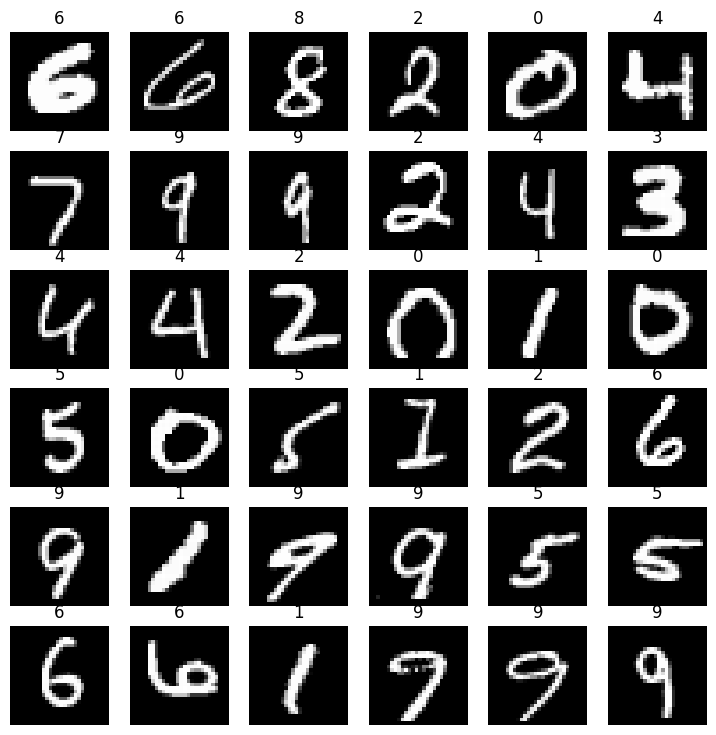

In [4]:
# Plot images
torch.manual_seed(42) #sets the random seed for reproducibility
fig = plt.figure(figsize=(9, 9)) #creates a matplotlib figure with size of 9x9 inches
rows, cols = 6,6
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() #Generates a random index within the range of the length of the training dataset 
    img, label = train_data[random_idx]  #Retrieves the image and label corresponding to the randomly chosen index 
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(),cmap="gray") # img.squeeze() is used to remove any singleton dimensions
    plt.title(class_names[label])
    plt.axis(False);

In [5]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
batch_size = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=batch_size , # how many samples per batch? 
    shuffle=True # it will shuffle data every epoch
)

test_dataloader = DataLoader(test_data,
    batch_size=batch_size,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001D1A3B1FBD0>, <torch.utils.data.dataloader.DataLoader object at 0x000001D1A3ACB510>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

- The first dimension, 32, indicates that the batch contains 32 samples (images).
- The second dimension, 1, represents the number of channels in each image (1=grayscale, 3=RBG scale)
- The last two dimensions, 28 and 28, represent the height and width of each image in pixels. 

# 2. Construct a Convolutional Neural Network

In [7]:
class MNISTModelCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
    
mnistmodel = MNISTModelCNN(input_shape=1,hidden_units=10,output_shape=len(class_names))

# 3. Decide the optimizer and loss function

In [8]:
# Using RMSprop optimizer
optimizer = torch.optim.RMSprop(params=mnistmodel.parameters(), lr=0.001)

# Optional: Set the maximum gradient norm for gradient clipping
max_grad_norm = 1.0  

# Use Loss FunctionCrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

**Optimizer Choice:RMSprop**
- Adaptability: RMSprop adapts learning rates individually for each parameter based on recent gradients, aiding convergence.- 
Dampening Effect: Dampening prevents learning rates from becoming too large, avoiding oscillations or divergence
- 
Sparse Data Handli: : Well-suited for MNIST's sparse image gradients, contributing to stable and efficient optimization during training.

**Loss Function Choice: CrossEntropyLoss**
- Softmax Activation: Suited for multi-class classification with softmax activation in the final layer.
- 
Logarithmic Nature: Penalizes confidently incorrect predictions more, contributing to better convergence
- 
Gradient Properties: Produces stable and efficient gradients during backpropagation.

# 4. Create a training loop (visualize test accuracy)

In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    model.train()  # Set the model to training mode
    train_loss, train_acc = 0, 0
    total_batches = len(data_loader)

    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Use item() to get the scalar value from the tensor
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= total_batches
    train_acc /= total_batches
    print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0
    total_batches = len(data_loader)

    with torch.no_grad():  # Disable gradient computation during testing
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y).item()

    # Adjust metrics and print out
    test_loss /= total_batches
    test_acc /= total_batches
    print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}%\n")

In [16]:
# Instantiate torchmetrics.Accuracy outside of the loops
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names))

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        model=mnistmodel, 
        data_loader=train_dataloader, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn  # Pass the same instance to both training and testing
    )
    test_step(
        model=mnistmodel,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn  # Pass the same instance to both training and testing
    )
        # Optional: Clip gradients to prevent exploding gradients
    if max_grad_norm is not None:
        nn.utils.clip_grad_norm_(mnistmodel.parameters(), max_grad_norm)

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.048 | Train accuracy: 0.985%


 33%|████████████████████████████▎                                                        | 1/3 [01:05<02:10, 65.49s/it]

Test loss: 0.044 | Test accuracy: 0.987%

Epoch: 1
---------
Train loss: 0.041 | Train accuracy: 0.987%


 67%|████████████████████████████████████████████████████████▋                            | 2/3 [02:11<01:05, 65.82s/it]

Test loss: 0.042 | Test accuracy: 0.986%

Epoch: 2
---------
Train loss: 0.037 | Train accuracy: 0.989%


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:17<00:00, 65.76s/it]

Test loss: 0.041 | Test accuracy: 0.987%



# 5. Plot the images with the wrongly predicted labels together with the true labels

In [17]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the model's predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item()  # Detach from the computational graph
    }

In [18]:
# Compute accuracy on test data using eval_model
mnistmodel_results = eval_model(
    model=mnistmodel,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names))
)

# Print or log the evaluation results
print(f"Evaluation Results:\n{mnistmodel_results}")

Evaluation Results:
{'model_name': 'MNISTModelCNN', 'model_loss': 0.04095645248889923, 'model_acc': 0.9873203039169312}


In [19]:
import numpy as np

# Set the model in evaluation mode
mnistmodel.eval()

# List to store mistake images
mistake_images = []

# Iterate over the test dataset and find mistakes
for images, labels in test_dataloader:
    # Forward pass through the model
    outputs = mnistmodel(images)
    
    # Get the predicted labels
    _, predicted_labels = torch.max(outputs, dim=1)
    #print(predicted_labels, labels)
    # Check if the prediction was correct
    for i in range(len(predicted_labels)):
        
        if predicted_labels[i] != labels[i]:
            mistake_images.append((images[i].squeeze(), labels[i].item(), predicted_labels[i].item()))

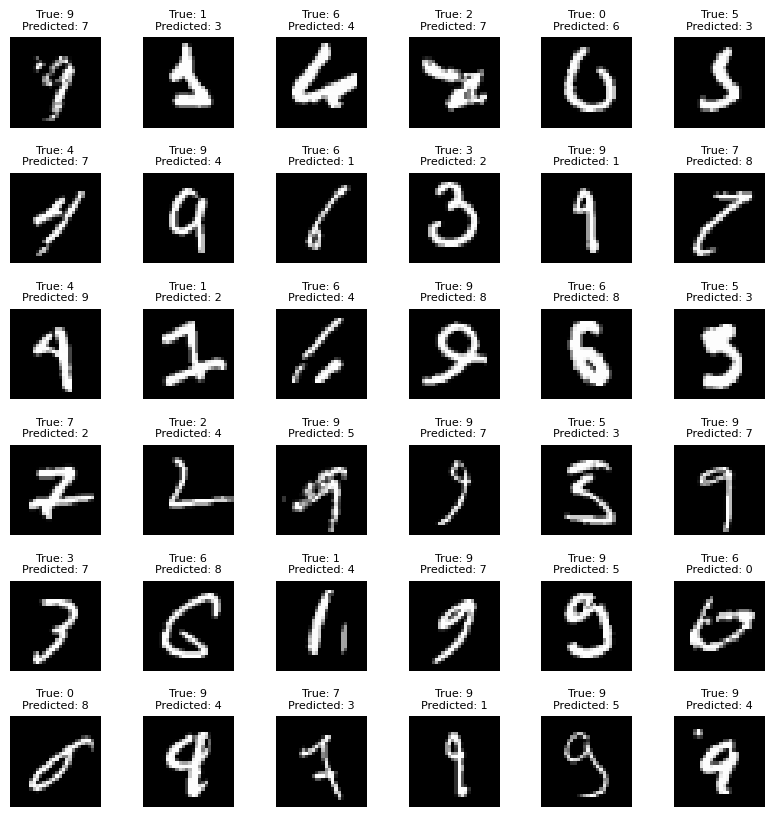

In [20]:
import random
# Create a subplot grid for displaying the images
fig, axes = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

# Iterate over the mistake images and plot them
for i, (image, true_label, predicted_label) in enumerate(random.sample(mistake_images, k=36)):
    # Convert the image tensor to numpy array
    image = image.numpy()
    
    # Reshape the image to its original dimensions (assuming it's flattened)
    image = np.reshape(image, (28, 28))
    
    # Plot the image along with the true and predicted labels
    ax = axes[i // 6, i % 6]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}',fontsize=8)
    ax.axis('off')

# Show the plot
plt.show()

# 6. Create a confusion matrix

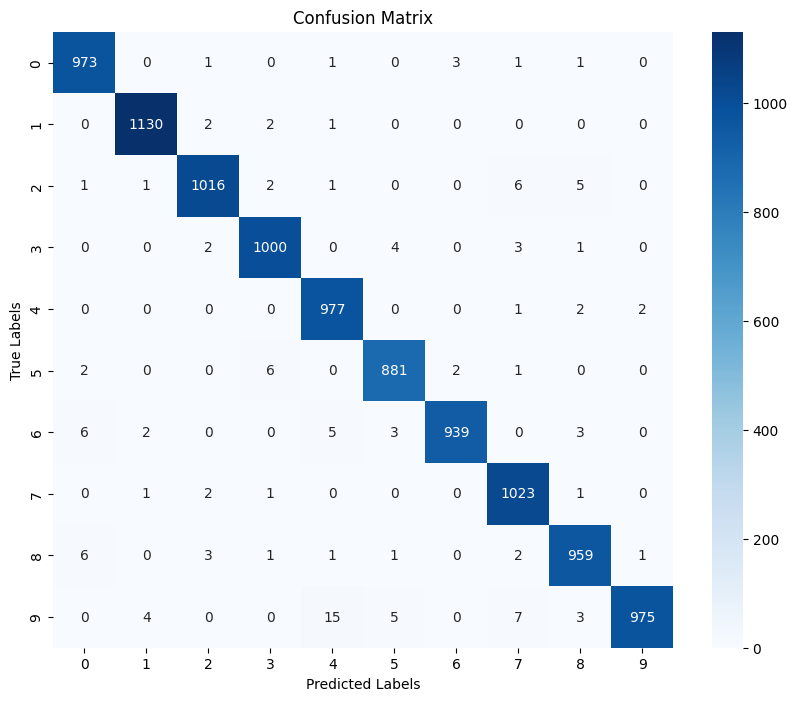

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the model in evaluation mode
mnistmodel.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and collect true and predicted labels
for images, labels in test_dataloader:
    # Forward pass through the model
    outputs = mnistmodel(images)
    
    # Get the predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Append true and predicted labels to the lists
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted.numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()